In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pymatreader import read_mat
import matplotlib.patches as mpatches
from scipy.stats import zscore 
%matplotlib inline

In [2]:
# set paths
DATA_PATH = 'data/eeg_prediction_corr.mat'

In [3]:
def tidy_eeg_predictions_f4(dataset, col_name):
    
    """
    local function to tidy the eeg & predicted data.
    input:
        dataset: dictionary to tidy and melt
        col_name: a random column name of the dict keys (this is needed for the formatting)
    """
    
    dataset[col_name]['time'] = np.arange(0.1,10.1,0.1)
    df = pd.melt(dataset[col_name], id_vars=['time'])
    df.drop(columns='value', inplace=True)
    df.rename(columns={'variable': 'subject'}, inplace=True)

    for key in dataset.keys():
        df[key] = pd.melt(dataset[key])['value']

    return df

In [4]:
def load_data_f4():
    
    """Loads, zscores and formats the data needed to create figure 4."""
    
    data_all = read_mat(DATA_PATH)

    # Read data and zscore
    predictions = {key : pd.DataFrame(val).apply(zscore)
                   for key, val in data_all['predictions'].items()}
    
    eeg = {key : pd.DataFrame(val).transpose().apply(zscore)
           for key, val in data_all['eeg'].items()}
    

    # tidy eeg & predictions
    data_eeg = tidy_eeg_predictions_f4(eeg, 'eeg_10k')
    data_predictions = tidy_eeg_predictions_f4(predictions, 'prediction_10k')

    # concatenate eeg & predictions data
    df = pd.concat([data_predictions, data_eeg], axis=1)
    
    # remove duplicate columns (time and subject information is equal in both dataframes and only needed once)
    df = df.loc[:,~df.columns.duplicated()]
    
    # remove the subject were modeling was unsuccessful (see manuscript)
    df = df.query('subject != 6')

    return df

In [5]:
# Load and preprocess data
df = load_data_f4()

# Melt df for line plots
df_lp = df.melt(['time', 'subject'], var_name='cols', value_name='vals')

In [6]:
def calculate_mse():
    """
    Computes the mean squared error between the measured ABR and the predicted activity 
    using only subsets of the data.
    """
    
    # select variables to use for mse comparison
    mse_comp_keys = df.keys().drop(['time', 'subject', 'eeg_10k', 'prediction_10k'])
     
    # calculate the squared error for each timepoint between the predicted(EEG, MEG) and the expected response
    for key in mse_comp_keys:   
        df.loc[:, key] = np.subtract(df['eeg_10k'], df[key])**2

    # separate data 
    predict = df[['subject', 'prediction_5k','prediction_1k', 'prediction_500', 'prediction_100', 'prediction_50']]
    eeg = df[['subject', 'eeg_5k', 'eeg_1k','eeg_500', 'eeg_100','eeg_50']]
    
    # calculate the mean of the squared errors per subject 
    eeg = eeg.groupby('subject').mean()
    predict = predict.groupby('subject').mean()

    return eeg, predict

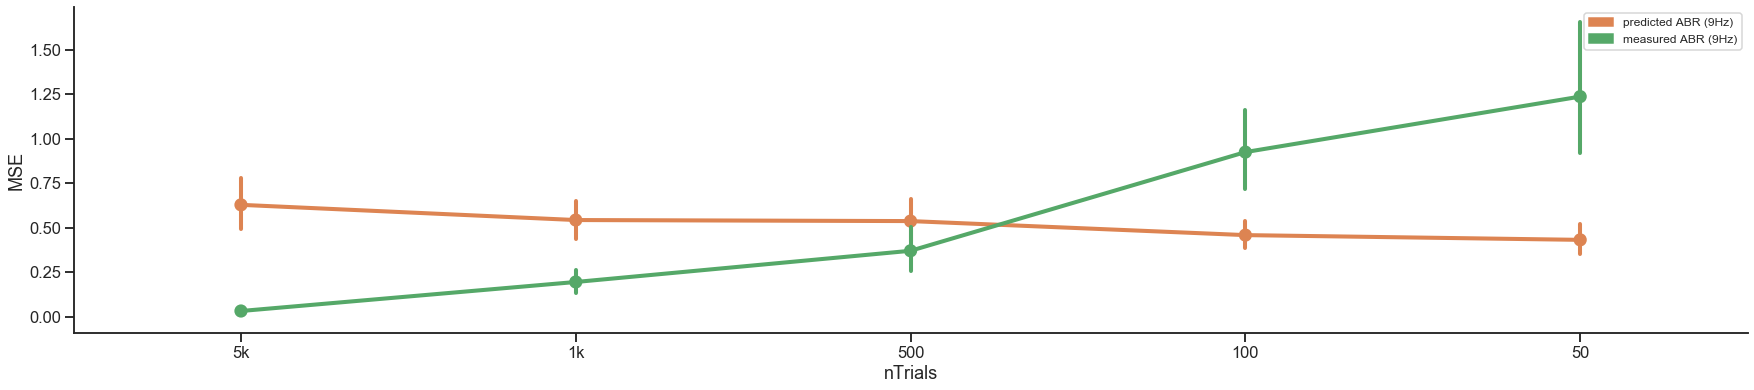

In [7]:
# plot the mse comparison per subject and condition
eeg, predict = calculate_mse()

# general seaborn setup
sns.set_style('ticks')
sns.set_context('talk', rc={'legend.fontsize': 12})

pred_plt = sns.pointplot(x='variable',
              y='value',
              data=predict.melt(),
              color =sns.color_palette("deep")[1])

eeg_plt = sns.pointplot(x='variable',
              y='value',
              data=eeg.melt(),
              color = sns.color_palette("deep")[2])

eeg_plt.set_ylabel('MSE')
eeg_plt.set_xlabel('nTrials')
eeg_plt.set_xticklabels(['5k', '1k', '500', '100', '50'])

patch_1 = mpatches.Patch(color=sns.color_palette("deep")[1], label='predicted ABR (9Hz)')
patch_2 = mpatches.Patch(color=sns.color_palette("deep")[2], label='measured ABR (9Hz)')
plt.legend(handles=[patch_1, patch_2])

eeg_plt.figure.set_size_inches(30, 6, forward=True)

sns.despine()

In [8]:
#function to do individual lineplots
def do_lineplot_f4(data, prediction, eeg, subject, ax=None):
    """
    Plots the measured and predicted ABR for individual subjects. 
    Note that subjects are not orderd as in the barplot. 
    to obtain the same subject id as in the barplot look into df of figure 2 and select the right index.
    
    Input:
        data: long format version of the preprocessed Dataframe
        prediction: refers to the modelled activity inferred from subsets of trials. Can be 'prediction_5k','prediction_1k', 'prediction_500', 'prediction_100', 'prediction_50'.
        eeg: refers to the predicted eeg activity inferred from subsets of trials. Can be 'eeg_5k', 'eeg_1k','eeg_500', 'eeg_100','eeg_50'.
        subject: digit referring to the index of a subject (can be 0-13)
    """
    
    data_to_plot = data.query('subject == %d' % subject)
    
    # general seaborn setup
    sns.set_style('ticks')
    sns.set_context('talk', rc={'legend.fontsize': 12})
    
    # query string to subselect data
    query_string = 'cols == "%s" or cols == "%s" or cols == "eeg_10k"' % (prediction, eeg)
        
    ax = sns.lineplot(
              x='time',
              y='vals',
              hue='cols',
              data=data_to_plot.query(query_string),
              palette="deep",
              linewidth=2,
              ax=ax)
    
    ax.set_ylabel("Amplitude (zscore)")
    ax.set_xlabel("Time (ms)")
    
    sns.despine()
    
    # setup legend
    plt.legend(loc=(0.8,0.8), labels=[prediction, eeg, 'eeg_10k']);
    
    # set aspect ratio
    plt.axis([0, 10,-3, 4])
    
    return ax

In [9]:
do_lineplot_f4(data = df_lp,
               prediction = 'prediction_50',
               eeg = 'eeg_50',
               subject = 0);